In [1]:
# making changes to tempdata

In [2]:
import numpy as np
import json
import sys
import pandas as pd
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings("ignore")

In [17]:
sys.path.insert(0, 'src')
from helper import *
from eda import *
from train import *

### etl (new readfilerun and gen)

In [4]:
def readfilerun(run_):#, output_dir):
    outdir = os.path.join(os.getcwd() , "data", "tempdata")
    names = listdir('data') # all filenames in data
    daneruns = [x for x in names if not 'losslog' in x]
    daneruns.remove('tempdata')
    
    # daneruns = ['data/20220116T055105_20-100-true-20-100-iperf.csv', 'data/20220116T055942_20-250-true-20-250-iperf.csv']
    losslogs = [x for x in names if 'losslog' in x]
    #print(losslogs)
    for count, run in enumerate(daneruns):
        print(count)
        # print(run) #for debug
        curr_losslog = losslogs[count]
        print("run: ", run)
        run_labels = run.split('_')[1].split('.')[0].split('-')
        print("run_labels:", run_labels)
        temp_label_str = '-'.join(run_labels) 
        #print(temp_label_str)
        losslog = f'data/{curr_losslog}' #losslog filename str
        #print(f'data3/{run}')
        #print(losslog)
        run_df = pd.read_csv(f'data/{run}')
        losslog_df = pd.read_csv(losslog, header=None).rename(
            columns={0:'event', 1:'drop_unix', 2:'IP1', 3:'Port1', 4:'IP2', 5:'Port2', 6:'Proto'})
        losslog_df['Time'] = losslog_df['drop_unix'].astype(int)
        df = pd.merge(run_df, losslog_df, on=['Time', 'IP1', 'Port1', 'IP2', 'Port2', 'Proto'], how="left") # merge on fivetuple key
        # df.fillna(inplace=True, value=-1) #TODO plan implementation of dealing with null values
        # df['event'] =  # TODO change to 3 different profiles: no drop, drop, and switch event
        df = df[df['Proto'] == df['Proto'].mode()[0]] # selects relevant non ipv6 int(connection
        
        ## adding labels
        df['latency'] = int(run_labels[0])
        df['loss'] = int(run_labels[1])
        df['later_latency'] = int(run_labels[3])
        df['later_loss'] = int(run_labels[4])
        df['deterministic'] = bool(run_labels[2])
        
        #TODO future implementation of boolean flag for when the switch happens so we know when to use later lat/loss
        
        df.to_csv(f'{outdir}/labeled-from-{run_}_{temp_label_str}.csv') # save to temporary output directory: just merging takes a bit

In [5]:
def gen(cond , subset):
    unseen = ""
    if cond == 'seen': 
        print("transforming seen data")
    if cond == 'unseen': 
        print("transforming un seen data")
        unseen = "unseen"
    tempdatafiles = listdir('data/tempdata')
    fnames = [ filename for filename in tempdatafiles if filename.endswith(".csv" ) ]
    
    data, datasubset, transformed  = [], [], []
    for j in fnames:
        loc = os.path.join(os.getcwd(), 'data', "tempdata", j)
        print(loc)
        df_cols = genfeat(pd.read_csv(loc))
        
        #data
        time_scaled = time(df_cols)
        data.append(time_scaled)
        
        #subset
        df_mid = time_scaled.iloc[60:60+subset]
        datasubset.append(df_mid)

        #transformed
        f_df = agg10(df_cols)
        transformed.append(f_df)
        
    # makes paths
    path = os.path.join(os.getcwd() , "outputs", "gen_temp")
    path2 = os.path.join(os.getcwd() , "outputs")
    
    list_to_csv(data, os.path.join(path2, unseen + "combined_all.csv"))
    print('combined_finished', sep=' ')
    list_to_csv(datasubset, os.path.join(path2, unseen + "combined_subset_6068.csv"))
    print('combined_all_finished', sep=' ')
    list_to_csv(transformed, os.path.join(path2, unseen +  "combined_transform.csv"))
    print('transformed_finished', sep=' ')
        
    return None
def list_to_csv(lst, filepth):
    '''takes list of pandas dataframes with similar column structure and outputs them to a single folder'''
    lst[0].to_csv(filepth, index=False)
    for i in range(1, len(lst)):
        lst[i].to_csv(filepth, index=False, header=False, mode='a')
    return


In [6]:
def genviz(cond, fname, subset):
    unseen = ""
    if cond == 'seen': 
        print("transforming seen data")
    if cond == 'unseen': 
        print("transforming un seen data")
        unseen = "unseen"

    data, datasubset, transformed  = [], [], []
    loc = os.path.join(os.getcwd(),"data", "tempdata", fname)
    
    t = pd.read_csv(loc)
    df_cols = genfeat(t)
    print(fname)
    run_labels = fname.split('_')[1].split('.')[0].split('-')
    print(run_labels)

    #data
    time_scaled = time(df_cols)
    data.append(time_scaled)

    #subset
    df_mid = time_scaled.iloc[:subset]
    datasubset.append(df_mid)

    #transformed
    f_df = agg10(df_cols)
    transformed.append(f_df)
    
    path = os.path.join(os.getcwd() , "outputs", "gen_temp")
    path2 = os.path.join(os.getcwd() , "outputs")
    label = run_labels[0] + '-' + run_labels[1] +  '__' + run_labels[3] + '-' + run_labels[4]
    temp_data = pd.concat(data , ignore_index=True)#.reset_index(drop = True)
    temp_data.to_csv(os.path.join(path2, unseen + "s_all_" + label + ".csv"), index = False)
    
    temp_subset = pd.concat(datasubset , ignore_index=True)
    temp_subset.to_csv(os.path.join(path2, unseen +  "s_subset_" + label + ".csv"), index = False)
    
    temp_t = pd.concat(transformed, ignore_index=True)  
    temp_t.to_csv(os.path.join(path2, unseen +  "s_transform_" + label + ".csv"), index = False)

#### eda

In [16]:
def main_eda(cond, lst, filen1, filen2, filen3):
    unseen = ''
    if cond =='unseen': 
        unseen = 'unseen'
    
    fpath1 = os.path.join(os.getcwd() , "outputs", unseen + filen1)
    df_1 = pd.read_csv(fpath1)
    fpath2 = os.path.join(os.getcwd() , "outputs", unseen + filen2)
    df_2 = pd.read_csv(fpath2)
    fpath3 = os.path.join(os.getcwd() , "outputs", unseen + filen3)
    df_3 = pd.read_csv(fpath3)
    
    plottogether(cond, lst, df_1, filen1.strip(".csv")) # trends over subset
    plottogether(cond, lst, df_3, filen3.strip(".csv")) # trends over entire data
    plotloss(cond, df_2)

    plot_correlation_matrix(cond, df_2) # correlation matrix
    plotlongest(df_3, cond, 600, 1400)
    # below makes rest of visualizations
    plotbytes(df_3, 600, 1400, 200, 200)
    #plot_detailed_bytes()

In [8]:
# overlaying model predictions and plotting detailed bytes

#### train

In [9]:
def test_feat(cond, df, cols, p, df_u): 
    unseen = ''
    if cond =='unseen': 
        unseen = 'unseen'
    # col is feauture comb
    # p is for loss or latency   1: loss  # 2 : latency
    X = df[cols]
    
    X2 = df_u[cols]

    if p == 1:  # flag found in test_mse
        y = df.loss
        y2 = df_u.loss
    if p == 2: 
        y = df.latency
        y2 = df_u.latency
        
    # randomly split into train and test sets, test set is 80% of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    if unseen == 'unseen': 
        X_test = X2
        y_test = y2
    
    clf = DecisionTreeRegressor()
    clf = clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    acc1 = mean_squared_error(y_test, y_pred)
    
    clf2 = RandomForestRegressor(n_estimators=10)
    clf2 = clf2.fit(X_train,y_train)
    y_pred2 = clf2.predict(X_test)
    acc2= mean_squared_error(y_test, y_pred2)
    
    clf3 = ExtraTreesRegressor(n_estimators=10)
    clf3 = clf3.fit(X_train,y_train)
    y_pred3 = clf3.predict(X_test)
    acc3= mean_squared_error(y_test, y_pred3)
    
    pca = PCA() 
    X_transformed = pca.fit_transform(X_train) 
    cl = DecisionTreeRegressor() 
    cl.fit(X_transformed, y_train)
    newdata_transformed = pca.transform(X_test)
    y_pred4 = cl.predict(newdata_transformed)
    acc4 = mean_squared_error(y_test, y_pred4)
    
    clf_gbc = GradientBoostingRegressor(random_state=0)
    clf_gbc.fit(X_train, y_train)
    y_pred5 = clf_gbc.predict(X_test)
    acc5 = mean_squared_error(y_test, y_pred5) 
    return [acc1, acc2, acc3, acc4, acc5]


def test_mse(cond, all_comb1, all_comb2):
    unseen = ''
    if cond =='unseen': 
        unseen = 'unseen'
    filedir_unseen = os.path.join(os.getcwd(), "outputs", unseen + "combined_t.csv")
    df_unseen = pd.read_csv(filedir_unseen)
    filedir = os.path.join(os.getcwd(), "outputs", "combined_t.csv")
    df = pd.read_csv(filedir)
    
    all_comb1 = pd.Series(all_comb1).apply(lambda x: list(x))
    all_comb2 = pd.Series(all_comb2).apply(lambda x: list(x))
    
    dt = []
    rf = []
    et = []
    pca = []
    gbc = []
    for i in all_comb1:
        acc_loss = test_feat(cond, df, i, 1, df_unseen)
        dt.append(acc_loss[0])  
        rf.append(acc_loss[1])  
        et.append(acc_loss[2])   
        pca.append(acc_loss[3])   
        gbc.append(acc_loss[4])
        
    # optimze by adding a flag called losslat to avoid making two dataframes of results
    dt2 = []
    rf2 = []
    et2 = []
    pca2 = []
    gbc2 = []
    for i in all_comb2:
        # 1 = loss
        # 2 = latency
        acc_latency = test_feat(cond, df, i, 2, df_unseen)
        dt2.append(acc_latency[0])
        rf2.append(acc_latency[1])
        et2.append(acc_latency[2]) 
        pca2.append(acc_latency[3])
        gbc2.append(acc_latency[4])
        
    dict1 = pd.DataFrame({'feat': all_comb1, 'dt': dt, 'rf': rf, 'et': et, 'pca': pca, 'gbc': gbc})
    dict2 = pd.DataFrame({'feat2': all_comb2, 'dt2': dt2, 'rf2': rf2, 'et2': et2, 'pca2': pca2, 'gbc2': gbc2})
    
    path = os.path.join(os.getcwd() , "outputs")
    dict1.to_csv(os.path.join(path, unseen + "feat_df1.csv"), index = False)
    dict2.to_csv(os.path.join(path, unseen + "feat_df2.csv"), index = False)


def best_performance(cond):
    unseen = ''
    if cond == 'unseen': 
        unseen = 'unseen'
    #print("finding best loss performance")
    filedir1 = os.path.join(os.getcwd(), "outputs", unseen + "feat_df1.csv")
    df1 = pd.read_csv(filedir1)
    print( "\n")
    print("Loss Performance sorted from lowest to highest", "\n")
    print(df1.sort_values(by=['dt', 'rf', 'et', 'pca'], ascending = True)[:5], "\n")
    
    #print("finding best latency performance")
    filedir2 = os.path.join(os.getcwd(), "outputs", unseen + "feat_df2.csv")
    df2 = pd.read_csv(filedir2)
    print( "\n")
    print("Latency Performance sorted from lowest to highest", "\n")
    print(df2.sort_values(by=['dt2', 'rf2', 'et2', 'pca2'], ascending = True)[:5], "\n")


#### main

In [10]:
def main(targets):

    transform_config = json.load(open('config/transform.json'))
    columns = json.load(open('config/columns.json'))
    eda_config = json.load(open('config/eda.json'))
    all_config = json.load(open("config/all.json"))

    test_unseen = 'unseen'
    test_seen = 'seen'
    
    cond1 = True
    cond2 = False

    if 'data' in targets:
        """generating feat from unseen and seen data"""
#         readfilerun('data', 'tempdata') 
        gen(test_seen, **transform_config)
#         gen(test_unseen, **transform_config)

    if 'eda' in targets:  
#         readfilerun('data', 'tempdata') 
#         gen(test_seen, **transform_config)
        main_eda(test_seen, [200, 200], **eda_config)
        print("EDA saved to outputs/eda/ folder")

    if 'train' in targets:
        "trains tests in this target"
#         readfilerun('data', 'tempdata') 
#         gen(test_seen, **transform_config)
                
        comb1 = getAllCombinations(1)
        comb2 = getAllCombinations(2)
        
        print("Testing on seen data: ")
        test_mse(test_seen, comb1, comb2)
        best_performance(test_seen)
                        
    if "inference" in targets: 
        print('tba')
#         readfilerun('data', 'tempdata') 
#         gen(test_seen, **transform_config)
#         gen(test_unseen, **transform_config)
        
#         comb1 = getAllCombinations(1)
#         comb2 = getAllCombinations(2)
        
#         print("Testing on unseen data: ")
#         test_mse(test_unseen, comb1, comb2)
#         best_performance(test_unseen)
            
    if "test" in targets: 
        """ runs all targets on sample data"""
        print('tba')
#         readfilerun('data', 'tempdata') 
#         gen(test_seen, **transform_config)
#         gen(test_unseen, **transform_config)
        
#         main_eda(test_seen, **eda_config)
#         print("EDA saved to outputs/eda/ folder")
        
#         comb1 = getAllCombinations(1)
#         comb2 = getAllCombinations(2)
        
#         print("Testing on seen data: ")
#         test_mse(test_seen, comb1, comb2)
#         best_performance(test_seen)
        
#         print("Testing on unseen data: ")
#         test_mse(test_unseen, comb1, comb2)
#         best_performance(test_unseen)
        
    if 'all' in targets: 
        print('tba')
        
# if __name__ == '__main__':

#     targets = sys.argv[1:]
#     main(targets)

In [11]:
targets = ['data', 'eda', 'train', 'inference', 'test', 'all']
# main(targets[0])

end of main4
end of main4
EDA saved to outputs/eda/ folder


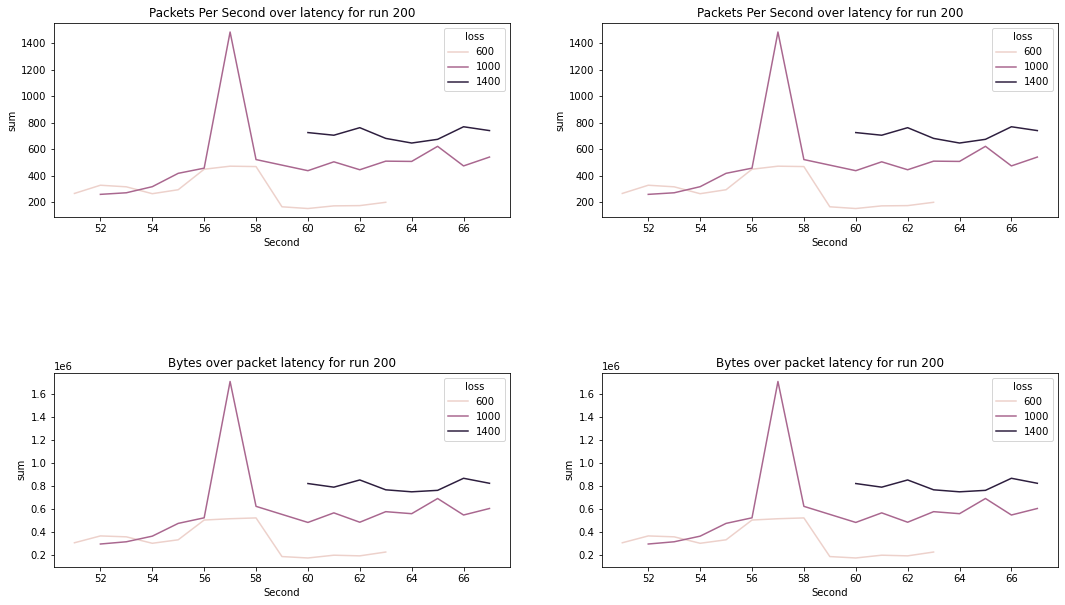

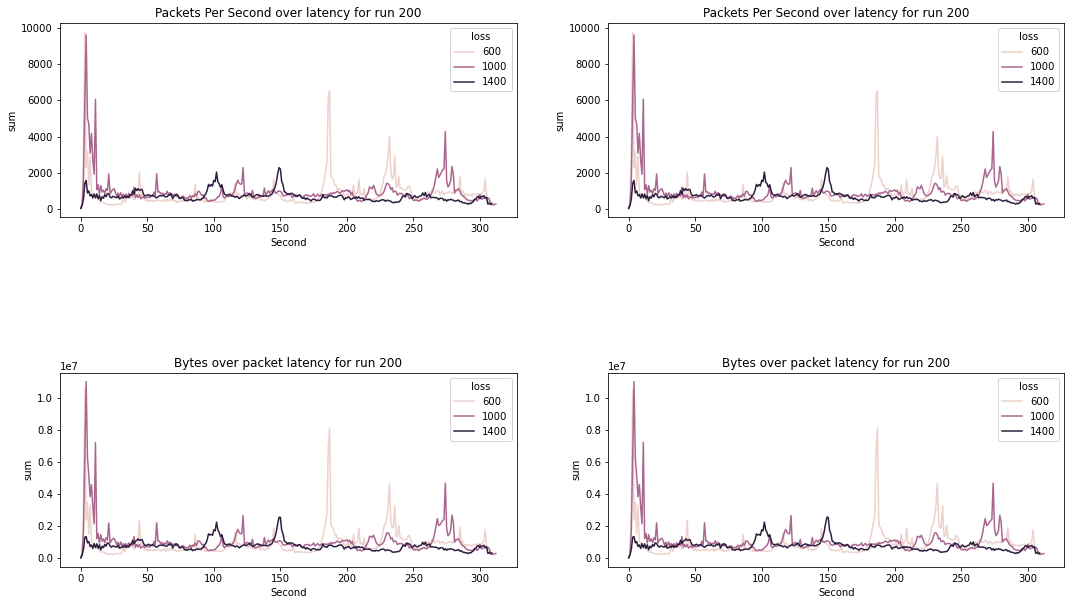

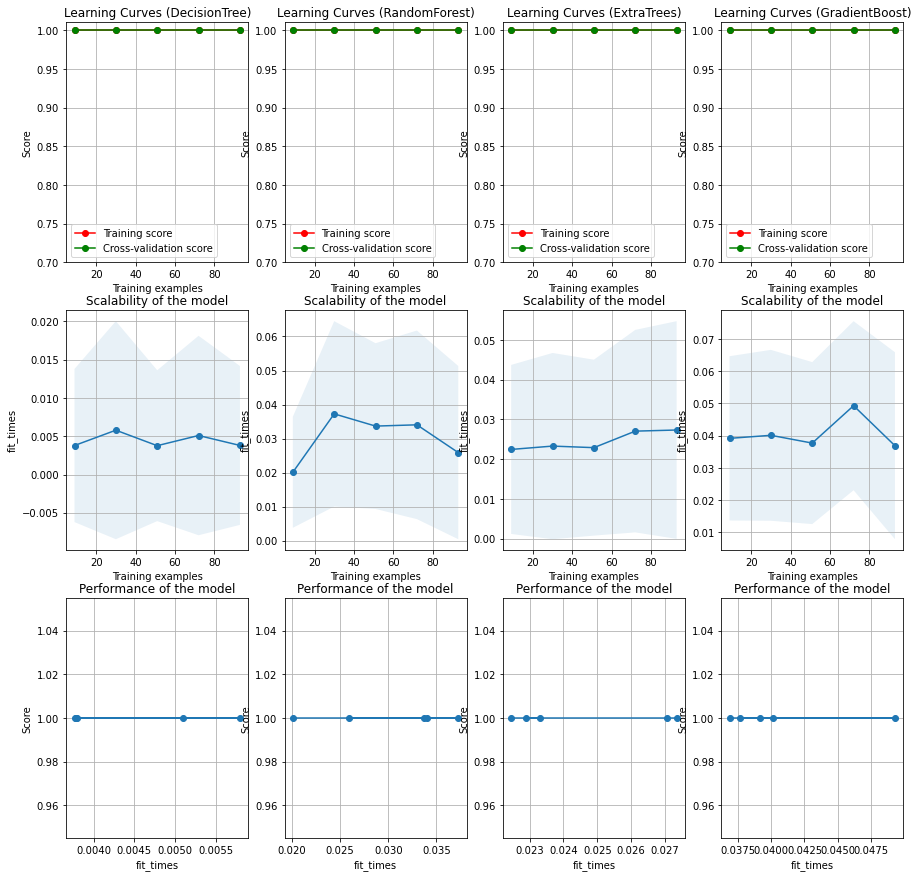

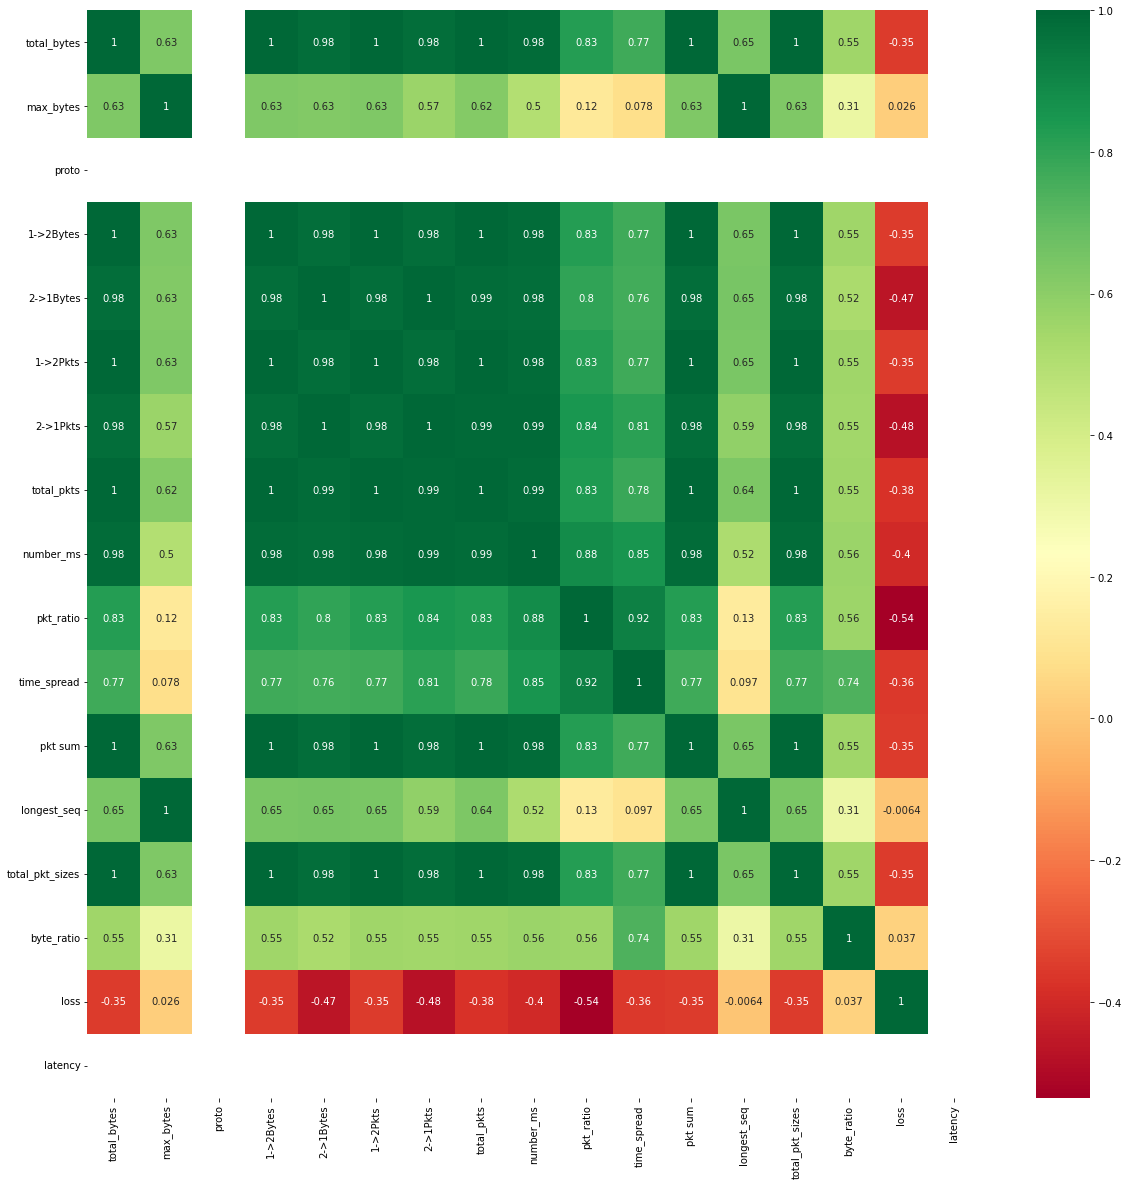

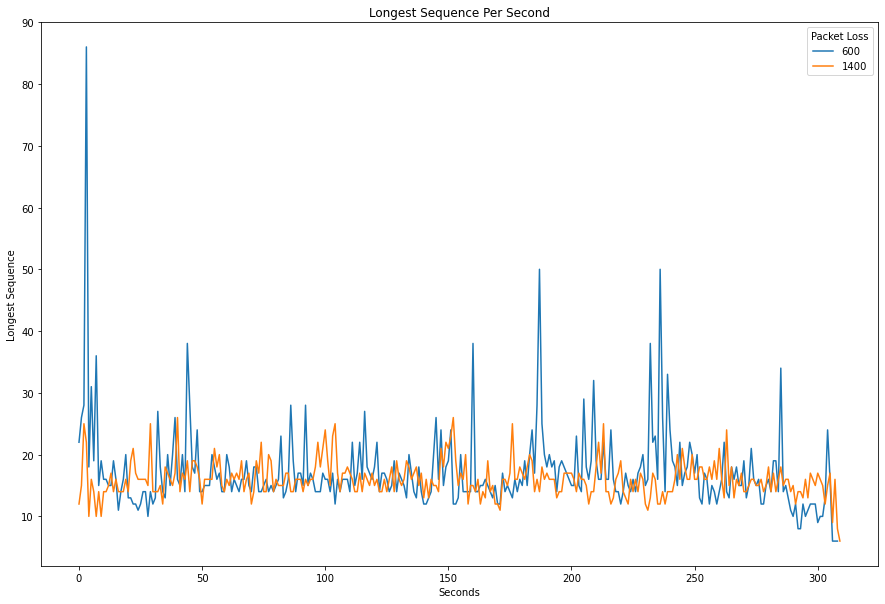

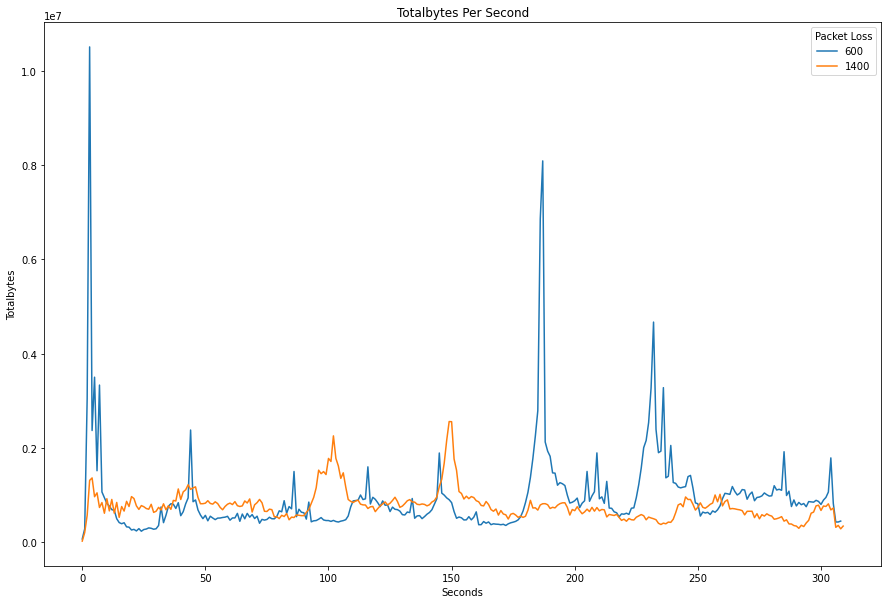

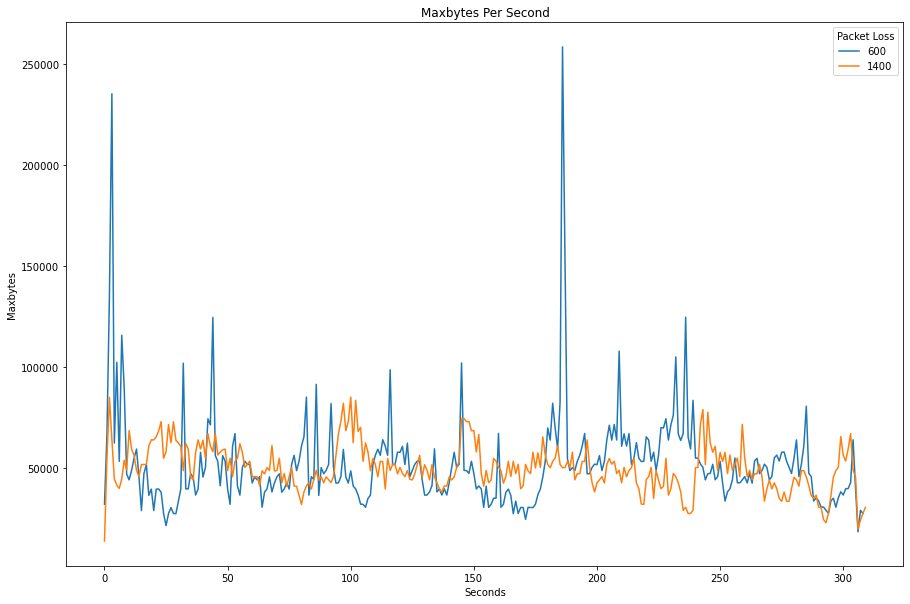

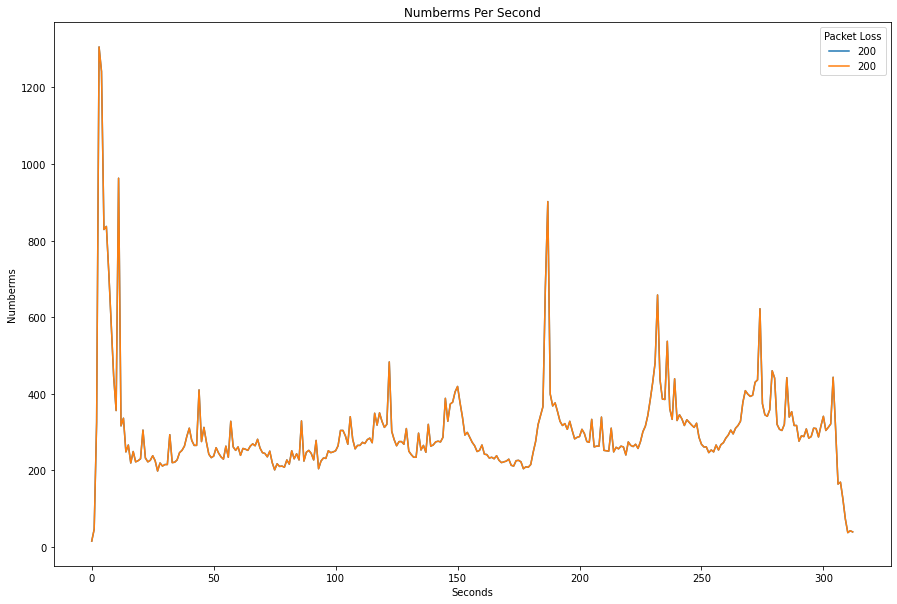

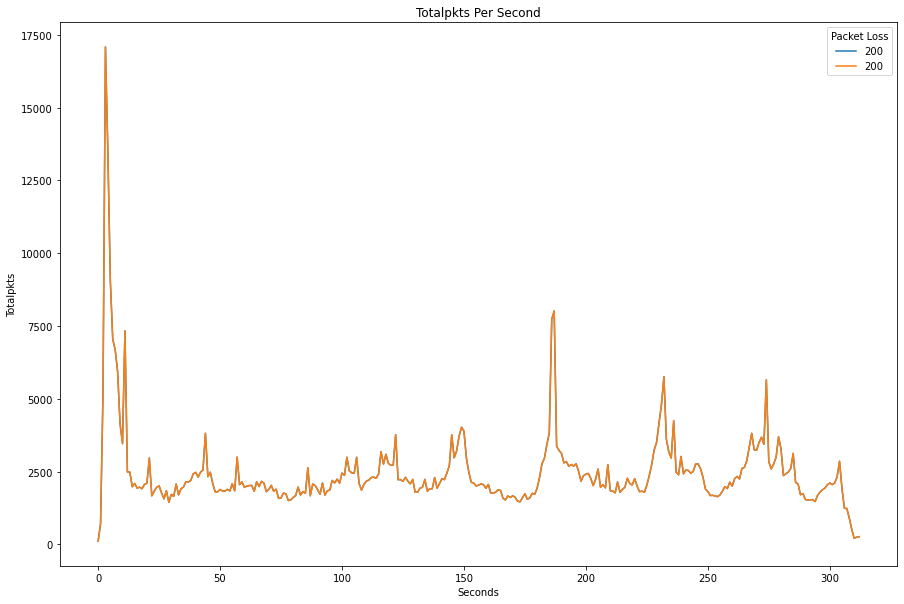

In [19]:
main(targets[1])

MAKING pipeline: , tst on data with change in loss later
    
    comb[some index]
    
    dt() - untrained
    
    dt( comb) - train, or grid search on it
    
    et() - 
    
    plot them on top of eachother
    
    test(single dataset - aggregated over subset )# overserved or not
    
    plot the bytes, loss records (loss log), and expanded model predictions

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline

path = os.path.join(os.getcwd() , "outputs")

In [14]:
comb1 = getAllCombinations(1)
comb2 = getAllCombinations(2)
comb1

all combinations generated
all combinations generated


[{'max_bytes'},
 {'max_bytes', 'total_bytes'},
 {'total_bytes'},
 {'longest_seq', 'max_bytes'},
 {'longest_seq', 'max_bytes', 'total_bytes'},
 {'longest_seq', 'total_bytes'},
 {'longest_seq'}]

In [15]:
#fname = 'labeled-from-data2_100-10000-true-100-10000.csv'
genviz('seen', fname, 8)

NameError: name 'fname' is not defined

In [ ]:
newfname = 'combined_t.csv'
s_t = pd.read_csv(os.path.join(os.getcwd() , "outputs", newfname))

In [ ]:
# expanding pipeline for two predictors? mainly loss is impt, latency less so
X, y = s_t[comb1[4]], s_t['loss']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=0)
pipe = Pipeline([('scaler', StandardScaler()), ('svc', GradientBoostingRegressor())])
 # The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set


clf = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=2, n_jobs=-1)


pipe.fit(X_train, y_train)
p = pipe.predict(X_test)
mean_squared_error(y_test, p)
#pipe.score(X_test, y_test)

In [ ]:
def plot_detailed_bytes(df, col='1->2Bytes', rollsec=10):
    rollcolor = '#6c2b6d'
    detailcolor = '#e98d6b'
    
    ax = plt.figure(figsize=(18,8))
    df[col].plot(title=f'{col}/s Rate', color=detailcolor)
    df[col].rolling(rollsec).mean().bfill().plot(color=rollcolor)
    plt.axvline(x=180, color='r')
    for i in df[df['event'] == 'drop'].index:
        plt.axvline(x=i, color='y', alpha=.45)
    custom_lines = [Line2D([0], [0], color=detailcolor, lw=2),
        Line2D([0], [0], color=rollcolor, lw=2),
        Line2D([0], [0], color='y', lw=2, alpha=0.45),
        Line2D([0], [0], color='r', lw=2)]
    plt.legend(custom_lines, 
               [f'{col} per Second', f'{col} per Second ({rollsec}s rolling avg)', 'Packet drop', '180s Mark'], 
               loc='upper right', framealpha=1);